In [3]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import random
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_Test.zip" -d "/content"

In [ ]:
## Descargamos y descomprimimos los pesos "AdvProp" más recientes
## de EfficientNetB2
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/advprop/efficientnet-b2.tar.gz
!tar -xf efficientnet-b2.tar.gz -C /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle

In [ ]:
## Convertimos los pesos a formato h5
!python /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnet_weight_update_util.py --model b2 --notop --ckpt \
        /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnet-b2/model.ckpt --o /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnetb2_advprop_notop.h5

In [6]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [7]:
## Creamos nuestro data_image_generator
train_image_generator = ImageDataGenerator(rotation_range = 90, 
                                           horizontal_flip = True,
                                           vertical_flip = True,
                                           validation_split = 0.2)

## Leemos las imágenes de train, validacion y test
training = train_image_generator.flow_from_directory(
  "Sentinel2LULC_354",
  subset="training",
  seed=1234,
  target_size=(224, 224),
  batch_size = 32,
  class_mode='sparse')

validation = train_image_generator.flow_from_directory(
  "Sentinel2LULC_354",
  subset="validation",
  seed=1234,
  target_size=(224, 224),
  batch_size = 32,
  class_mode='sparse')

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)


Found 8236 images belonging to 29 classes.
Found 2030 images belonging to 29 classes.
Found 1618 files belonging to 1 classes.


2022/03/15 12:07:53 INFO mlflow.tracking.fluent: Experiment with name 'EfficientNetB2 con DataAugmentation (AdvProp)' does not exist. Creating a new experiment.


Epoch 1/25
258/258 [==============================] - 169s 574ms/step - loss: 2.7316 - accuracy: 0.5063 - val_loss: 1.7573 - val_accuracy: 0.5433
Epoch 2/25
258/258 [==============================] - 144s 557ms/step - loss: 1.6859 - accuracy: 0.5974 - val_loss: 1.5135 - val_accuracy: 0.6025
Epoch 3/25
258/258 [==============================] - 149s 576ms/step - loss: 1.3361 - accuracy: 0.6265 - val_loss: 1.2582 - val_accuracy: 0.6291
Epoch 4/25
258/258 [==============================] - 142s 551ms/step - loss: 1.1903 - accuracy: 0.6350 - val_loss: 1.3112 - val_accuracy: 0.6236
Epoch 5/25
258/258 [==============================] - 142s 549ms/step - loss: 1.1503 - accuracy: 0.6393 - val_loss: 1.2629 - val_accuracy: 0.6099
Epoch 6/25
258/258 [==============================] - 144s 559ms/step - loss: 1.1012 - accuracy: 0.6502 - val_loss: 1.3064 - val_accuracy: 0.6300


2022/03/15 12:22:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


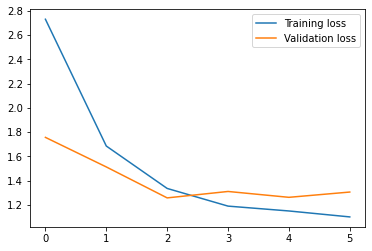

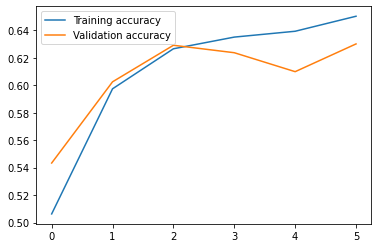

In [8]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Vamos a entrenar usando la red EfficietNetB2
base_model = tf.keras.applications.EfficientNetB2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnetb2_advprop_notop.h5',
                                               pooling='avg')

base_model.trainable = False

normalization = Rescaling(1./255)
prediction_layer = Dense(29, activation="softmax")

model = Sequential([
  #normalization,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])

opt = Adam(learning_rate=1e-2)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("EfficientNetB2 con DataAugmentation (AdvProp)")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=25,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/10
258/258 [==============================] - 266s 961ms/step - loss: 1.3534 - accuracy: 0.6107 - val_loss: 1.0878 - val_accuracy: 0.6764
Epoch 2/10
258/258 [==============================] - 245s 948ms/step - loss: 0.7315 - accuracy: 0.7620 - val_loss: 0.7613 - val_accuracy: 0.7754
Epoch 3/10
258/258 [==============================] - 245s 949ms/step - loss: 0.5966 - accuracy: 0.8027 - val_loss: 0.7804 - val_accuracy: 0.7754
Epoch 4/10
258/258 [==============================] - 245s 950ms/step - loss: 0.5075 - accuracy: 0.8281 - val_loss: 0.6865 - val_accuracy: 0.8015
Epoch 5/10
258/258 [==============================] - 245s 949ms/step - loss: 0.4354 - accuracy: 0.8493 - val_loss: 0.7863 - val_accuracy: 0.7877
Epoch 6/10
258/258 [==============================] - 246s 951ms/step - loss: 0.4002 - accuracy: 0.8617 - val_loss: 0.6848 - val_accuracy: 0.8094
Epoch 7/10
258/258 [==============================] - 245s 948ms/step - loss: 0.3646 - accuracy: 0.8706 - val_loss: 0.6573 -

2022/03/15 13:04:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


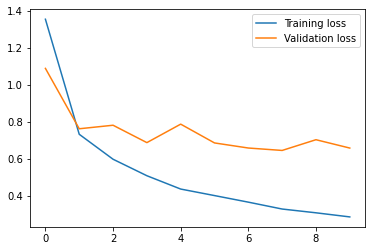

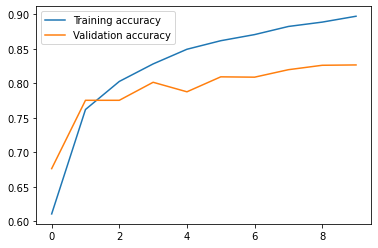

In [9]:
## FINE TUNING: Volvemos a entrenar descongelando algunas capas (menos las BatchNormalization)

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    opt = Adam(learning_rate=1e-4)
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])


unfreeze_model(model)

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=10,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [10]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ...  9  9  9]


In [11]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('EfficientNetB2_AdvProp.csv', index=False)
files.download('EfficientNetB2_AdvProp.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>